In [1]:
import hmc_tomography
import numpy

# Tutorial 0.1 - Getting started

In this tutorial, you will see all the essentials of using `hmc_tomography`. We will cover the following topics:

1. Creating and sampling from a distribution;
2. Investigating your samples;
3. Accessing the raw samples and misfits;
3. Interrupting sampling;
4. Using Bayes' rule.

To start, we will sample one of the most common distributions in statistics, the standard normal distribution. To sample anything in this framework, we need an instance of the distribution class we wish to sample. Here is how we create a standard normal distribution in 1 dimension:

In [2]:
distribution = hmc_tomography.Distributions.StandardNormal1D()

Every distribution object should have a few essential methods and attributes, which will be covered in the tutorial on implementing your own inverse problem. However, maybe the most important attribute of any distribution is its dimensionality, indicating the dimensions of the model space:

In [3]:
distribution.dimensions

1

In [4]:
issubclass(
    type(distribution),
    hmc_tomography.Distributions._AbstractDistribution,
)

True

As expected, the 1 dimensional standard normal distribution has 1 dimension. Great!

## Sampling for the first time

To generate samples of the distribution, one can use the methods contained in the submodule `hmc_tomography.Samplers`. As of yet, it only has the vanilla HMC algorithm. 

Running the associated `sample()` method requires you to **minimally** pass the **distribution** and the **filename** of the h5 file you wish to write to. This h5 file will be created if it does not exist. If it does exist, the program will prompt you with options on how to continue.

<div class="alert alert-warning">

**Note:** .h5 files
    
The sample files with extension .h5 are a special kind of files that are designed to hold a lot of data.  They were specifically chosen for hmc_tomography because MCMC generates large amounts of data. 
    
The samplers in this package buffer samples to RAM, and flush them intermittently to the hard drive. This is to allow for sample sizes bigger than RAM (by writing to disk) as well as avoiding continuous writes to disk which might slow down sampling (by buffering).
    
However, these files are not the easiest to work with. They require either an API to access them (in Python `h5py`) or a specialized program (e.g. `HDFCompass`). There are no easy ways to 'have a peek' in the file if you're not a little experienced with the file format.
    
In this package, we provide a class (`hmc_tomography.Post.Samples`) that allows us to work in an easy way with the samples. However, they should **ALWAYS** be used in a Python context manager, as shown in the section `Investigating your samples`.

</div>


Any other setting has defaults for all samplers, such that *you* can get started quickly. 

For the Hamiltonian Monte Carlo algorithm, important settings you could change include:
1. Mass matrix;
2. Amount of integration steps;
3. Integration time step.
4. ...

You can find detailed descriptions of all the parameters in the API reference.

In [5]:
filename = "bin_samples/tutorial_01_standard_normal.h5"

hmc_tomography.Samplers.HMC().sample(
    filename, distribution, overwrite_existing_file=True
)

sys:1: Warning: 
Silently overwriting samples file (bin_samples/tutorial_01_standard_normal.h5) if it exists.


Great! We just generated 100 samples from the distribution. The total acceptance rate was 1.00, and the acceptance rate of the last 100 samples (coincidentally the total amount of samples) is also 1.00. These numbers are rounded, so at a high amount of samples there might still be some rejected samples if you see 1.00.

In the next cell, we try to write to the same samples file again, so the sampler also asks us for permission to overwrite the previous file.

This package allows you to run the `sample()` method on either the instance, or directly on the class. What this means is that the previous and the following code snippets do the same thing:

In [6]:
hmc_instance = hmc_tomography.Samplers.HMC()

hmc_instance.sample(
    "bin_samples/tutorial_01_standard_normal.h5",
    distribution,
    proposals=10000,
    overwrite_existing_file=True,
)

Sneakily, I've now also passed an extra argument: proposals. This controls how many proposals the algorithm makes. How many of those are accepted still depends on other settings! 

## Investigating your samples

Now that we have some samples generated on disk, we should do something useful with them! 

As a first step, we should verify some attributes of the generated samples. We can do this by using a Python context manager. The reason for this is that this construct closes the file properly when we are done with it.

One of the helpful functions that `Samples` provides is `print_details()`, showing the final statistics of the Markov Chain:

In [7]:
with hmc_tomography.Samples("bin_samples/tutorial_01_standard_normal.h5") as samples:
    samples.print_details()


                                H5 file details                                 
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Filename                       bin_samples/tutorial_01_standard_normal.h5
Dataset                        samples_0

                              Sampling attributes                               
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Sampler                        Hamiltonian Monte Carlo
Requested proposals            10000
Online thinning                1
Proposals per second           12220.50
Proposals saved to disk        10000
Acceptance rate                1.00
Sampler initiate time          06-Nov-2020 (16:05:52.730949)
Sampler terminate time         06-Nov-2020 (16:05:53.565733)

                          Sampler specific attributes                           
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
amount_of_steps                10
in

We might wish to visualize the resulting distribution. Luckily, there is a visualization module, `hmc_tomography.Post.Visualization`.

This module contains multiple helpful functions to start with. One of them is `marginal`:

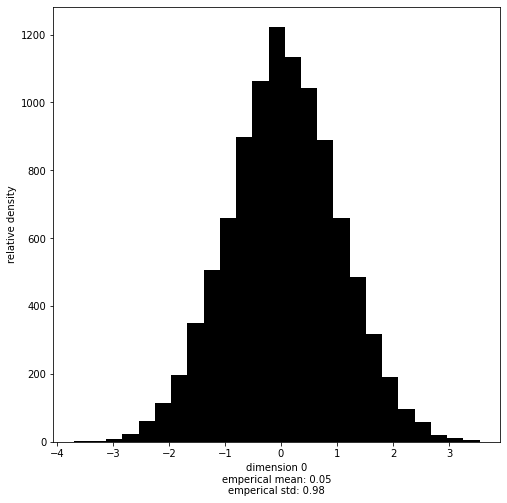

In [8]:
with hmc_tomography.Samples("bin_samples/tutorial_01_standard_normal.h5") as samples:
    hmc_tomography.Visualization.marginal(
        samples, 0, bins=25  # Note that dimensions are zero indexed
    )

## Accessing the raw samples and misfits

Sometimes you want more control over your samples. Luckily, we got your back. You can access the samples both as a NumPy array as well as the actual HDF5 dataset object. 

If you know how to work with it, accessing via HDF is faster, as it doesn't necessarily load all samples into RAM before slicing.

In [9]:
with hmc_tomography.Samples("bin_samples/tutorial_01_standard_normal.h5") as samples:

    # Access samples as a numpy array
    print(f"Type:  {type(samples.numpy)}")
    print(f"Shape: {samples.numpy.shape}")
    print()

    # Access samples as a HDF dataset
    print(f"Type:  {type(samples.h5)}")
    print(f"Shape: {samples.h5.shape}")

Type:  <class 'numpy.ndarray'>
Shape: (2, 10000)

Type:  <class 'h5py._hl.dataset.Dataset'>
Shape: (2, 10000)


You might notice the the `raw_samples_hdf` attribute has one extra dimension. That is because the samples file also records the misfits of each sample. We can easily access these as a NumPy array in the following way:

In [10]:
with hmc_tomography.Samples("bin_samples/tutorial_01_standard_normal.h5") as samples:

    # Access misfits as a numpy array
    print(f"Type:  {type(samples.misfits)}")
    print(f"Shape: {samples.misfits.shape}")
    print()

Type:  <class 'numpy.ndarray'>
Shape: (10000, 1)



Accessing the data directly might be handy when you need to compute some properties of a parameter, or wish to visualize some behaviour of the Monte Carlo sampler. 

Here is an example where we plot the evolution of parameter 1 and the misfit during the Markov chain, as well as printing statistics on parameter 1:

emperical mean: 0.35
emperical standard deviation: 0.20


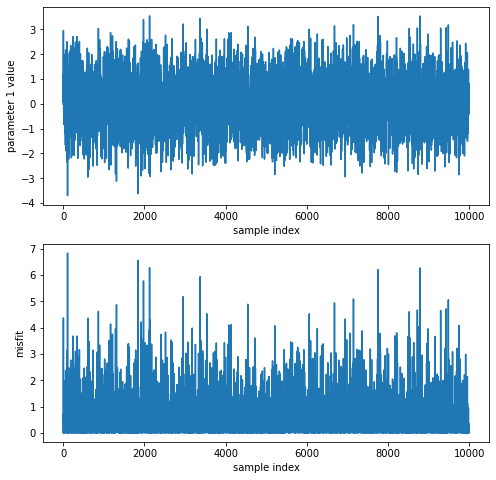

In [11]:
import matplotlib.pyplot as plt

with hmc_tomography.Samples("bin_samples/tutorial_01_standard_normal.h5") as samples:

    plt.figure(figsize=(8, 8))

    plt.subplot(211)
    plt.plot(samples[0, :])
    plt.xlabel("sample index")
    plt.ylabel("parameter 1 value")

    plt.subplot(212)
    plt.plot(samples.misfits)
    plt.xlabel("sample index")
    plt.ylabel("misfit")

    print(f"emperical mean: {samples[:,1].mean():.2f}")
    print(f"emperical standard deviation: {samples[:,1].std():.2f}")

## Interrupting sampling: no big deal

Sometimes you think you have the perfect settings for your 'run', and then after half an hour realize sampling is going to take longer than expected. At least, we experienced this a lot during our work with HMC.

Luckily, we've added some nice functionality in this specific case. When a sampler is busy doing his thing, and you want it to wrap up, simply interrupt the process. What this means is you either **once** press `CTRL + C` when you're running from a terminal, or press the stop button (■) at the top if you're in a Jupyter Notebook. This ensures that the algorithm gracefully wraps up, leaving your dear samples intact.

Try this out with the next cell. Let it progress to some percentage, and interrupt the kernel.

In [12]:
hmc_tomography.Samplers.HMC().sample(
    "bin_samples/tutorial_01_standard_normal.h5",
    distribution,
    proposals=100000,
    online_thinning=100,
    overwrite_existing_file=True,
    max_time=3.0,
)

sys:1: Warning: 
Silently overwriting samples file (bin_samples/tutorial_01_standard_normal.h5) if it exists.


When we now inspect the resulting samples file, we see that because we interrupted the kernel, the `proposals saved to disk` is less than we would expect after dividing `requested proposals` by `online thinning` (i.e. the number we would expect if the sampler finished).

In [13]:
with hmc_tomography.Samples("bin_samples/tutorial_01_standard_normal.h5") as samples:
    samples.print_details()


                                H5 file details                                 
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Filename                       bin_samples/tutorial_01_standard_normal.h5
Dataset                        samples_0

                              Sampling attributes                               
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Sampler                        Hamiltonian Monte Carlo
Requested proposals            100000
Online thinning                100
Proposals per second           14043.59
Proposals saved to disk        422
Acceptance rate                1.00
Sampler initiate time          06-Nov-2020 (16:05:54.480026)
Sampler terminate time         06-Nov-2020 (16:05:57.502740)

                          Sampler specific attributes                           
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
amount_of_steps                10
i

## Interpreting multidimensional results

In [14]:
# These guys have to be column vectors
mean = numpy.array([[-1.2], [4]])
std = numpy.array([[1.0], [4.5]])
variance = std ** 2


normal_2d = hmc_tomography.Distributions.Normal(mean, variance)

/home/larsgebraad/Documents/Hamiltonian Monte Carlo/hmc-tomography/hmc_tomography/Distributions/base.py:403: Warning: Seems that you only passed a vector as the covariance matrix. It will be used as the covariance diagonal.
  Warning,


In [15]:
hmc_tomography.Samplers.HMC().sample(
    "bin_samples/tutorial_01_mvn.h5",
    normal_2d,
    stepsize=1.5,
    proposals=25000,
    overwrite_existing_file=True,
)

sys:1: Warning: 
Silently overwriting samples file (bin_samples/tutorial_01_mvn.h5) if it exists.


One of the most interesting things to investigate when sampling from multidimensional distributions is the trade-off between different parameters. We can visualize these (second order) trade-offs by inspecting the 2D marginals. We supply a function that can create a set of 2D marginals from a samples object, by specifying which dimensions should be investigated:

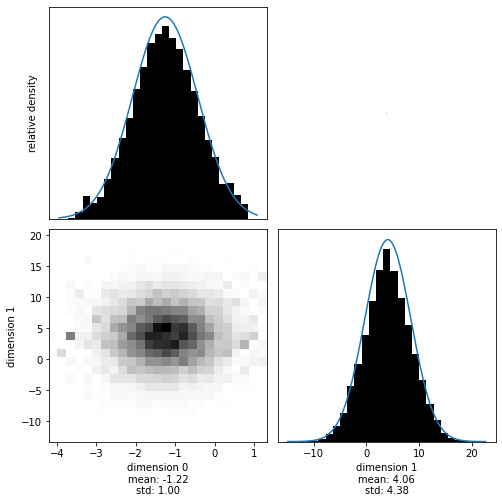

In [16]:
with hmc_tomography.Samples("bin_samples/tutorial_01_mvn.h5") as samples:
    hmc_tomography.Visualization.marginal_grid(
        samples, [0, 1], bins=25  # Note that dimensions are zero indexed
    )

If you want to investigate sampler behaviour, it is often beneficial to look at a trace plot of the Markov chain. In the next cell, we visualize the evolution of parameter 2 (dimension 1, due to zero based index). We give this function only the first 250 samples.

Additionally, the used function creates the 2D marginal with another dimension and plots the autocorrelation function of these two parameters during the supplied samples.

These types of plots can help us identify problems with sampling and assess convergence.

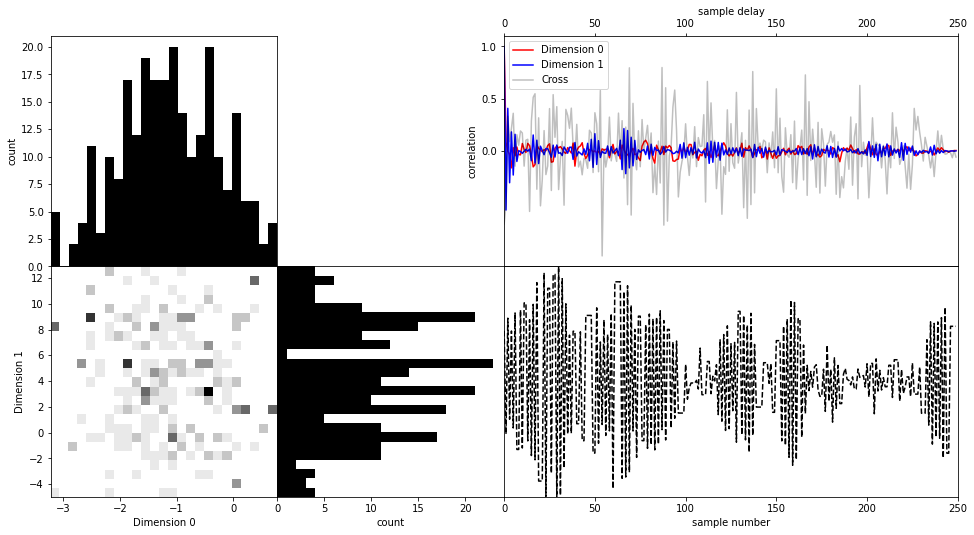

In [17]:
with hmc_tomography.Samples("bin_samples/tutorial_01_mvn.h5") as samples:
    hmc_tomography.Visualization.visualize_2_dimensions(
        samples[:, :250],
    )  # Note that we only pass the first 250 samples

## Using Bayes' rule

One of the main operations users of Bayesian inference do is applying Bayes' rule to two distributions. Bayes' rule combines two distributions (typically a likelihood and a prior) to a combined state of information, the posterior. We provide a simple interface to combine two or more distributions using Bayes' rule in the following way.

First we create two distributions we wish to combine. The first distribution is a 2D uniform distribution bounded between $[0, 1]$ for both parameters:

In [18]:
lower_bounds = numpy.zeros((2, 1))
upper_bounds = numpy.ones((2, 1))

distribution_1 = hmc_tomography.Distributions.Uniform(
    lower_bounds=lower_bounds, upper_bounds=upper_bounds
)

The next distribution is a mutlivariate (uncorrelated) normal distribution with varying means and standard deviations:

In [19]:
mean = numpy.array([[-0.1], [0.75]])
std = numpy.array([[0.1], [0.25]])
variance = std ** 2

distribution_2 = hmc_tomography.Distributions.Normal(mean, variance)

/home/larsgebraad/Documents/Hamiltonian Monte Carlo/hmc-tomography/hmc_tomography/Distributions/base.py:403: Warning: Seems that you only passed a vector as the covariance matrix. It will be used as the covariance diagonal.
  Warning,


The hmc_tomography package additionally warns us that it assumed the passed variance object was the diagonal of a covariance matrix. This is fine, as we don't want to define any correlations in this distribution.

We can use Bayes' rule by passing a list of distributions to the method `hmc_tomography.Distributions.BayesRule`. The returned distribution will contain the originally passed distributions completely.

In [20]:
posterior = hmc_tomography.Distributions.BayesRule([distribution_1, distribution_2])

The generated distribution can then be investigated using the samplers:

In [21]:
hmc_tomography.Samplers.HMC().sample(
    "bin_samples/tutorial_01_posterior.h5",
    posterior,
    proposals=10000,
    overwrite_existing_file=True,
)

sys:1: Warning: 
Silently overwriting samples file (bin_samples/tutorial_01_posterior.h5) if it exists.


Upon visualization we see the influence of both the uniform distributions (truncating the posterior at their limits) as well as the multivariate normal distribution:

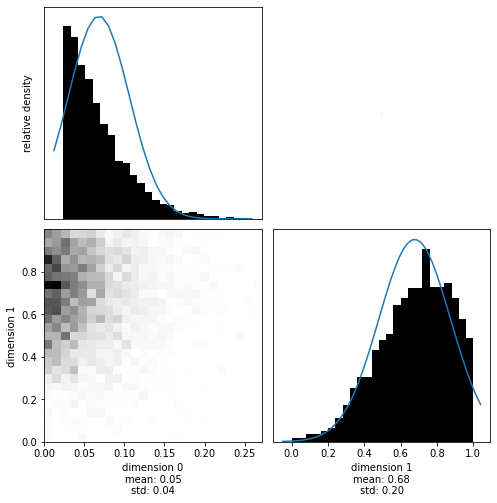

In [22]:
with hmc_tomography.Samples("bin_samples/tutorial_01_posterior.h5") as samples:

    hmc_tomography.Visualization.marginal_grid(samples, [0, 1])